# Sales Data Analysis
This dataset includes store information and sales numbers for Walmart. Sales are recorded in weekly intervals with store number and departmend id. Objective is to predict weekly sales for Walmart. First, classical time series analysis will be conducted. Considering there are insightful features in this dataset, second step will be conducting feature engineering and machine learning (Random Forest Regressor) to predict sales.
1. **EDA and preprocessing:** E-commerce dataset will be analyzed and processed for next steps.
2. **Classical Time-series models:** Forecasting revenue for next month.
3. **Machine Learning and Feature Engineering on Time-series:** Impact of store information, holidays etc.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import datetime as dt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# 1. Data Preprocessing and Exploratory Data Analysis

In [2]:
sales = pd.read_csv("train.csv")
print(sales.shape)
sales.head()

(421570, 5)


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [3]:
sales['Weekly_Sales'].describe()

count    421570.000000
mean      15981.258123
std       22711.183519
min       -4988.940000
25%        2079.650000
50%        7612.030000
75%       20205.852500
max      693099.360000
Name: Weekly_Sales, dtype: float64

Minimum amount of sales shows negative value so I will filter them out.

In [4]:
sales = sales[sales['Weekly_Sales']>0]

Date feature converted into datetime type and index for the data.

In [5]:
sales['Date'] = pd.to_datetime(sales['Date'])
sales.set_index('Date', inplace=True)
sales.sort_index(inplace=True)
sales.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-05,15,21,3253.19,False
2010-02-05,15,20,4606.90,False
2010-02-05,15,19,1381.40,False
2010-02-05,15,18,2239.25,False


Text(0.5, 1.0, 'Weekly Average Sales')

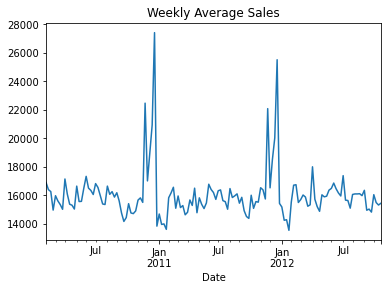

In [6]:
sales_weekly = sales.groupby(['Date'])['Weekly_Sales'].mean()

sales_weekly.plot()
plt.title('Weekly Average Sales')
# sales['Weekly_Sales'].resample('W').mean().plot()

Time series would be stationary if mean and variance do not change over time. Above graph gives not certain answer whether series is stationary or not. So let's check it with ADF and KPSS tests.

In [7]:
def adf_test(series, check = 0.05):
    
    adf = adfuller(series, autolag = "AIC")
    
    print(f"H0: {series.name} Series is non-stationary or series has a unit root.")
    print(f"H1: {series.name} is stationary or series has no unit root.\n")
    
    test_stat = adf[0]; print(f"ADF test statistic: {round(adf[0],4)}")
    pvalue = adf[1]; print(f"p-value: {round(adf[1],7)}")
    print(f"Number of lags: {adf[2]}")    
    print("\nCritical Values : \n")
    for key, item in adf[4].items(): print("\t", key, "\t", item)
    
    print(f"\nFor {check} significance level: \n")
    if pvalue < check:
        print("We can reject null hypothesis. This series is stationary or has no unit root.")
    else:
        print("We can not reject null hypothesis. This series is non-stationary or has a unit root.")

In [8]:
adf_test(sales_weekly, check=0.05)

H0: Weekly_Sales Series is non-stationary or series has a unit root.
H1: Weekly_Sales is stationary or series has no unit root.

ADF test statistic: -5.9271
p-value: 2e-07
Number of lags: 4

Critical Values : 

	 1% 	 -3.47864788917503
	 5% 	 -2.882721765644168
	 10% 	 -2.578065326612056

For 0.05 significance level: 

We can reject null hypothesis. This series is stationary or has no unit root.


In [9]:
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

    
kpss_test(sales_weekly)

KPSS Statistic: 0.04809878937205982
p-value: 0.1
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


**Stationarity Result:** ADF and KPSS tests imply that series is stationary in terms of process has no unit root and is trend stationary.

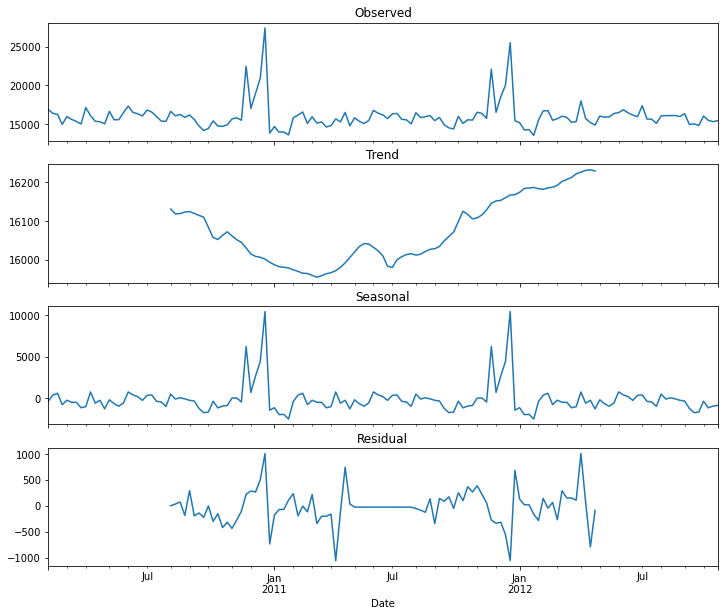

In [10]:
decompose = seasonal_decompose(sales_weekly)

fig, ax = plt.subplots(4, 1, sharex = True, figsize = (12, 10))

decompose.observed.plot(ax = ax[0]).set_title("Observed")
decompose.trend.plot(ax = ax[1]).set_title("Trend")
decompose.seasonal.plot(ax = ax[2]).set_title("Seasonal")
decompose.resid.plot(ax = ax[3]).set_title("Residual")

plt.show()

Series is stationary and models can be trained for forecasting sales. Further, decompositon of the model shows no trend.

In case not-stationary case, series could be differenced or transformed. 

In [11]:
len(sales_weekly)

143

## Split Train-Test data

In [12]:
def train_test(data, frac=0.90):
    train_data = data.iloc[:int(frac*(len(data)))]
    test_data = data.iloc[int(frac*(len(data))):]
    return train_data, test_data

In [13]:
train_data, test_data = train_test(sales_weekly)

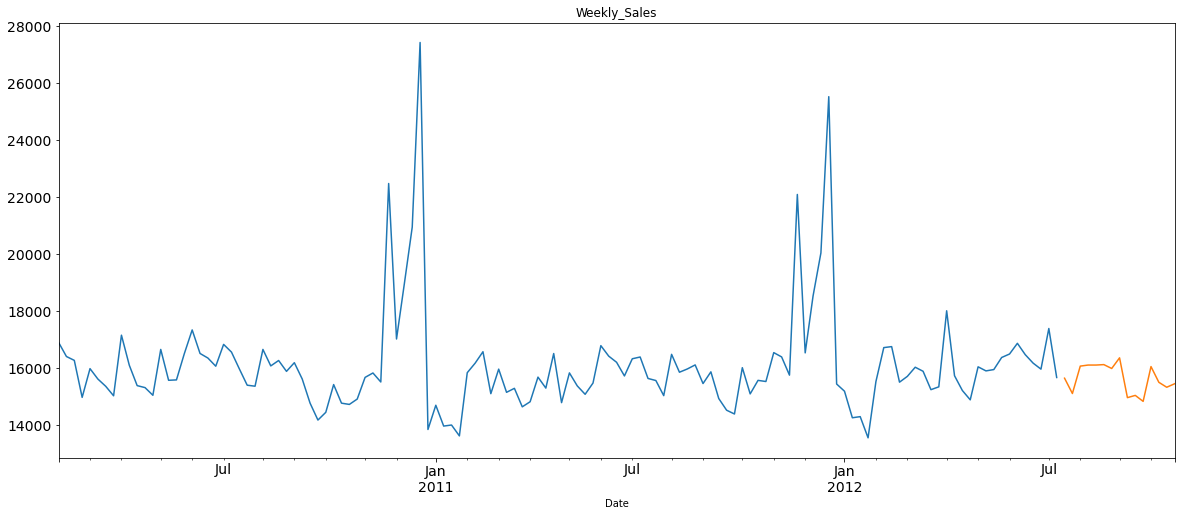

In [14]:
train_data.plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
test_data.plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.show()

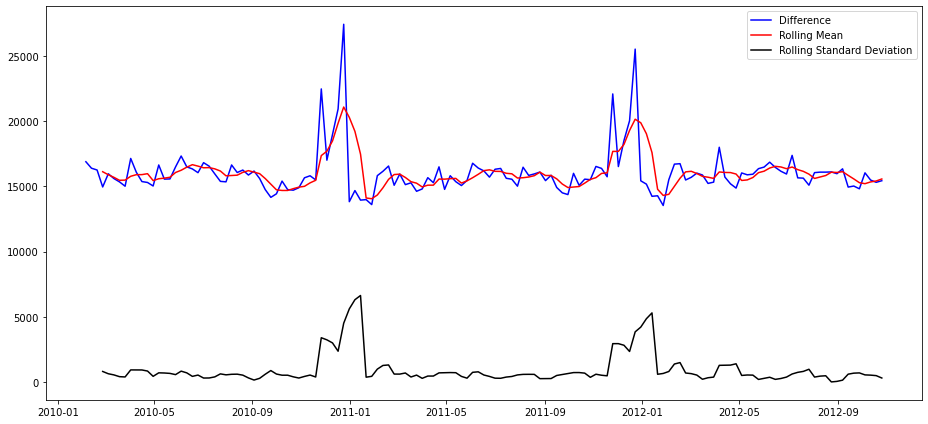

In [15]:
rmean = sales_weekly.rolling(4).mean()    #monthly rolling mean
rstd = sales_weekly.rolling(4).std()

fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(sales_weekly, color='blue',label='Difference')
ax.plot(rmean, color='red', label='Rolling Mean')
ax.plot(rstd, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

Rolling window of size 4 shows smoothened number of sales and no trend for the series.

# 2. Time-Series Models

## 2.1 Arima

#### PACF - ACF graphs

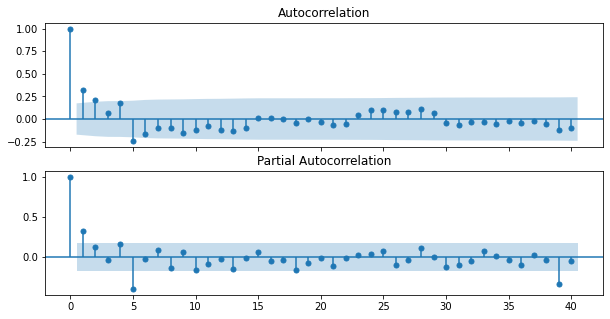

In [16]:
fig, ax = plt.subplots(2, 1, sharex = True, figsize=(10,5))
plot_acf(train_data, lags=40, ax=ax[0])
plot_pacf(train_data, lags=40, ax=ax[1])
plt.show()

ACF and PACF are important to determine ARIMA model through detecting hidden patterns and seasonality in time series when series is already stationary.
- ACF shows correlation between time series with a lagged version of itself. Indicates q in MA(q) order.
- PACF shows partial correlation of time-series with its own lagged values. Indicates the AR(p) order.
- ARIMA(p, d, q) refers to the model with p autoregressive terms, q moving-average terms and d number of nonseasonal differences.

Here, ACF plot slowly decays after 3rd lag indicates q=3 and PACF plot slowly decays after 2nd lag indicates for p=2 values where d=0 for this stationary series. Therefore, ARIMA(2,0,3) model can be fitted to the series.

In [17]:
# Fitting the ARIMA(2,0,3) model
model = ARIMA(train_data, order=(2,0,3))
model_arima = model.fit()

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


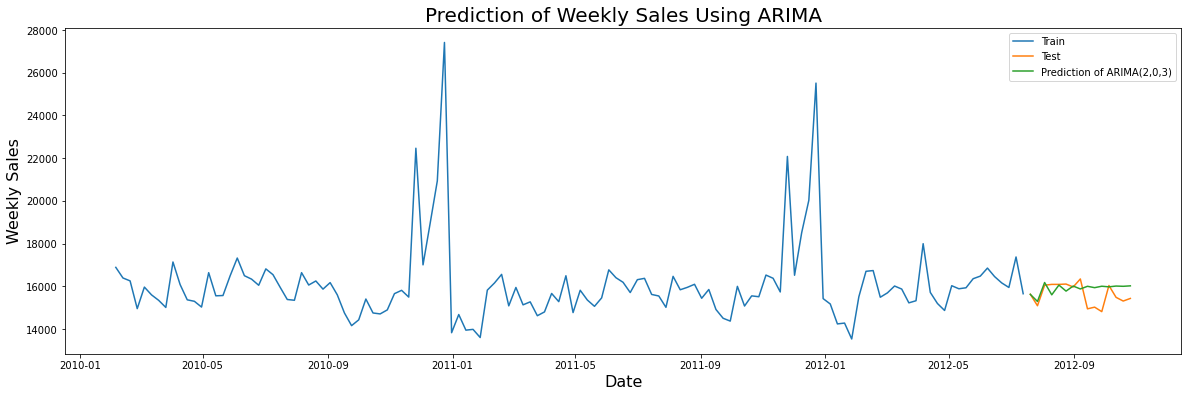

In [18]:
ypred_arima, se, conf = model_arima.forecast(len(test_data))    # Prediction with ARIMA for the test data
ypred_arima = pd.DataFrame(ypred_arima,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using ARIMA', fontsize=20)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(ypred_arima, label='Prediction of ARIMA(2,0,3)')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Weekly Sales', fontsize=16)
plt.show()

In [19]:
arima_res = mae(test_data, ypred_arima)
arima_res

447.71568708835065

## 2.2 Auto-Arima

In [20]:
model_auto_arima = auto_arima(train_data, trace=True,start_p=0, d=0, start_q=0, start_P=0, start_Q=0,
                  max_p=3, max_q=3, max_P=3, max_Q=3, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore')
model_auto_arima.fit(train_data)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=2295.729, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=2287.753, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=2284.716, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=2284.441, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=2283.628, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=2284.880, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=2286.727, Time=0.12 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=2288.711, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=2283.825, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=2285.808, Time=0.24 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=2285.162, Time=0.50 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=2279.107, Time=0.36 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=2285.681, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=2287.685, Time=0.19 sec
 ARIMA(3,0,2)(0,0,0)[1] intercept   : AIC=2285.283, Time=0.60 sec

Best mode

ARIMA(maxiter=200, order=(2, 0, 3), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

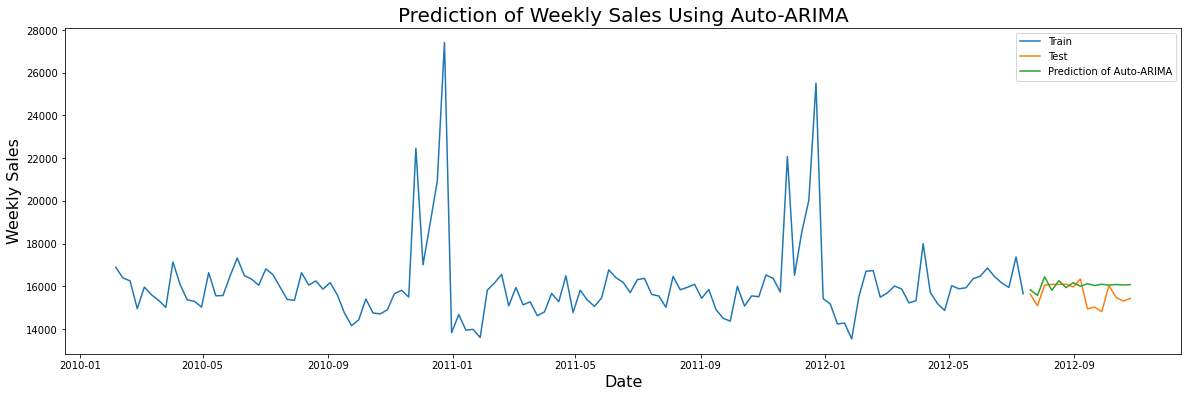

In [21]:
ypred_autoarima = model_auto_arima.predict(n_periods=len(test_data))    # Predict the test data
ypred_autoarima = pd.DataFrame(ypred_autoarima ,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(ypred_autoarima, label='Prediction of Auto-ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Weekly Sales', fontsize=16)
plt.show()

In [22]:
autoarima_res = mae(test_data, ypred_autoarima)
autoarima_res

514.5539897363572

Auto-ARIMA(2,0,3)(0,0,0,1) is similar to ARIMA(2,0,3), however, it accounts seasonality and gives different prediction on the test data

## Holt-Winters Model

In [23]:
model_holt_winters = ExponentialSmoothing(train_data, seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped=True).fit() #Taking additive trend and seasonality

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


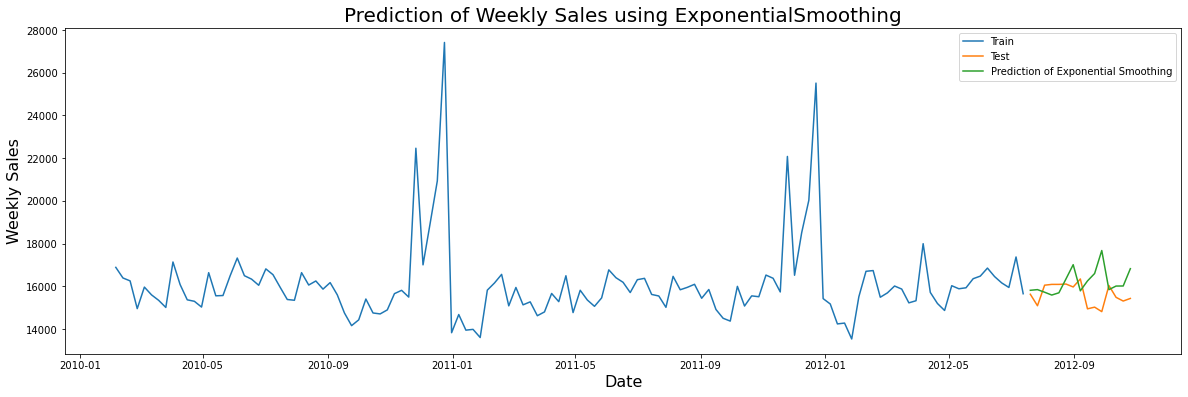

In [24]:
ypred_hw = model_holt_winters.forecast(len(test_data))    # Predict the test data

#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(ypred_hw, label='Prediction of Exponential Smoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Weekly Sales', fontsize=16)
plt.show()

In [25]:
expsmoothing_res = mae(test_data, ypred_hw)
expsmoothing_res

837.7561160809372

## Model Comparison
#### Mean absolute error results and graph on forecasting

In [26]:
results = dict({'arima_res':arima_res, 'autoarima_res':autoarima_res, 'expsmoothing_res':expsmoothing_res})

model_results = pd.DataFrame({
    'Model Name':results.keys(),
    'MAE': results.values()
}).sort_values('MAE')

model_results

,Model Name,MAE
0,arima_res,447.715687
1,autoarima_res,514.553990
2,expsmoothing_res,837.756116


Text(0, 0.5, 'Weekly Sales')

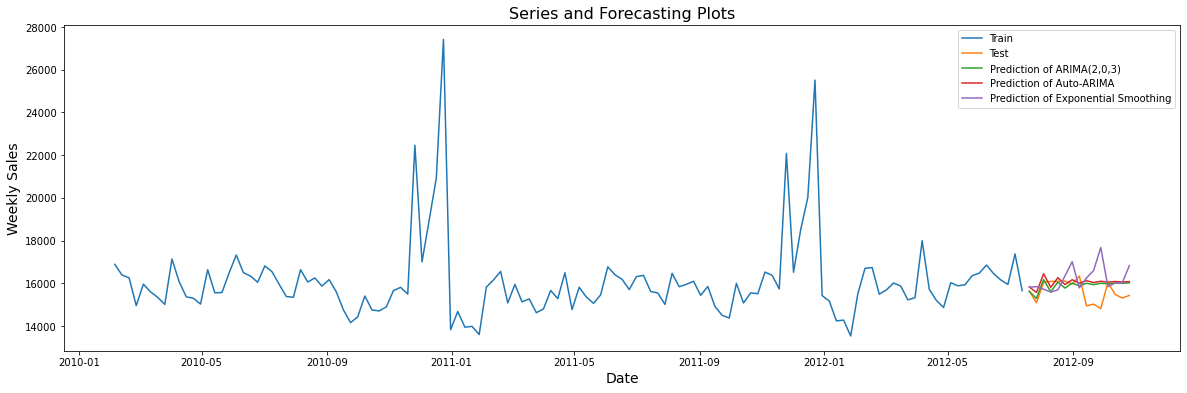

In [27]:
plt.figure(figsize=(20,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(ypred_arima, label='Prediction of ARIMA(2,0,3)')
plt.plot(ypred_autoarima, label='Prediction of Auto-ARIMA')
plt.plot(ypred_hw, label='Prediction of Exponential Smoothing')

plt.title('Series and Forecasting Plots', fontsize=16)
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)

In [28]:
test_data

Date
2012-07-20    15629.411697
2012-07-27    15091.508648
2012-08-03    16053.456116
2012-08-10    16090.911806
2012-08-17    16090.857333
2012-08-24    16106.388534
2012-08-31    15970.176590
2012-09-07    16344.419692
2012-09-14    14946.569084
2012-09-21    15025.385190
2012-09-28    14815.621125
2012-10-05    16037.442175
2012-10-12    15484.696200
2012-10-19    15311.314544
2012-10-26    15433.541013
Name: Weekly_Sales, dtype: float64

Text(0, 0.5, 'Weekly Sales')

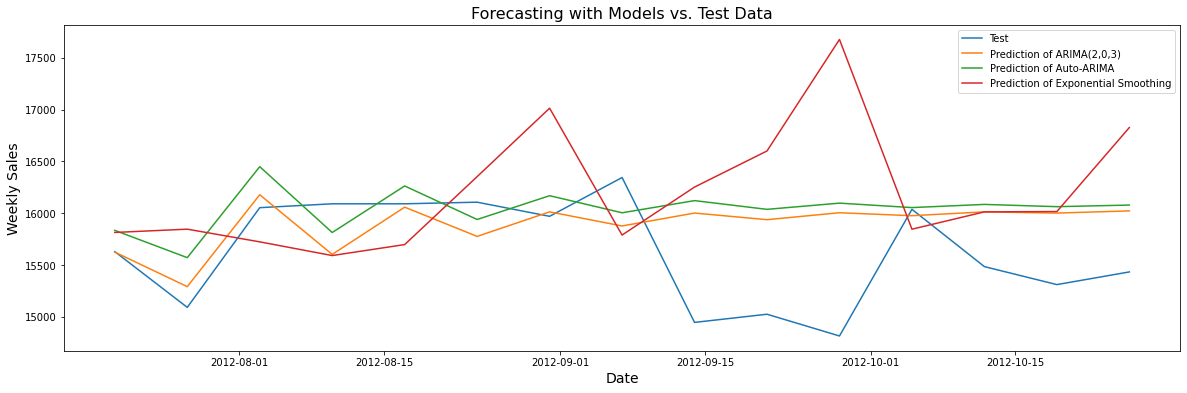

In [29]:
plt.figure(figsize=(20,6))
plt.plot(test_data, label='Test')
plt.plot(ypred_arima, label='Prediction of ARIMA(2,0,3)')
plt.plot(ypred_autoarima, label='Prediction of Auto-ARIMA')
plt.plot(ypred_hw, label='Prediction of Exponential Smoothing')

plt.title('Forecasting with Models vs. Test Data', fontsize=16)
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)

Mean absolute error is used for model evaluation criteria. ARIMA(2,0,3) model has the best performance among the models for forecasting. Exponential smoothing is useful when there is trend so it can flatten trend by adding damping parameter to make it converge into a constant value in the future, but this series is already trend stationary. As a result, exponential smoothing doesn't give good performance.

# 3. Machine Learning on Time-Series

## Read and explore datasets

In [30]:
sales = pd.read_csv("train.csv")
print('Sales data dims:', sales.shape)
sales.head()

Sales data dims: (421570, 5)


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [31]:
stores = pd.read_csv("stores.csv")
print('Stores data dims:', stores.shape)
stores.head()

Stores data dims: (45, 3)


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [32]:
features = pd.read_csv("features.csv")
print('Features data dims:', features.shape)
features.head()

Features data dims: (8190, 12)


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


## Merge datasets

In [33]:
data = sales.merge(stores, on="Store").merge(features, on=["Store", "Date", "IsHoliday"])
print(data.shape)
print(data.info())
data.head()

(421570, 16)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     150681 non-null  float64
 10  MarkDown2     111248 non-null  float64
 11  MarkDown3     137091 non-null  float64
 12  MarkDown4     134967 non-null  float64
 13  MarkDown5     151432 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB
None


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106


**Total store and department numbers**

In [34]:
pd.DataFrame([{"Stores": data['Store'].nunique(),
              "Departments": data['Dept'].nunique()}], index=['Unique'])

,Stores,Departments
Unique,45,81


**First and last date**

In [35]:
print("Starting Date: {}\nLast Date: {}".format(data['Date'].min(), data['Date'].max()))

Starting Date: 2010-02-05
Last Date: 2012-10-26


In [36]:
data.describe()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,136727.915739,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289
std,12.785297,30.492054,22711.183519,60980.583328,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296
min,1.000000,1.000000,-4988.940000,34875.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000
25%,11.000000,18.000000,2079.650000,93638.000000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000
50%,22.000000,37.000000,7612.030000,140167.000000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000
75%,33.000000,74.000000,20205.852500,202505.000000,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000
max,45.000000,99.000000,693099.360000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000


Stores are ordered properly from 1 to 45. Contrarily, there are 81 unique departments, however, they are ordered from 1 to 99 which shows that some of stores are missing in the dataset.

Weekly sales minimum is negative which must be an error or returned orders might be accounted for negative values but no way to understand it from this dataset. Therefore, only positive sales are included for forecasting purpose.

In [37]:
data = data[data['Weekly_Sales']>0]

## Missing values

In [38]:
data.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270031
MarkDown2       309308
MarkDown3       283561
MarkDown4       285694
MarkDown5       269283
CPI                  0
Unemployment         0
dtype: int64

Markdown column helps to see promotion effects on the sales. NaN values are not good for prediction later, so I'm changing them to 0 if there is no sales and leaving their values if there is sales.

In [39]:
data = data.fillna(0)

## Duplicated Entries

In [40]:
data.duplicated().sum()

0

No duplicated entries exist in the dataset.

## Markdown feature to detect whether there is sales or not

In [41]:
data = data.assign(Markdown_total=lambda data: data['MarkDown1']+data['MarkDown2']+data['MarkDown3']+data['MarkDown4']+data['MarkDown5'])

data['Markdown_cond'] = np.where(data['Markdown_total']>0, 1, 0); data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Markdown_total,Markdown_cond
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0.0,0
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0.0,0
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0.0,0
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0.0,0
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0.0,0


## Date Operations

Date feature should be datetime type. (Y-m-d)

In [42]:
data['Date'] = pd.to_datetime(data['Date'], format=('%Y-%m-%d'))

Adding Week, Month and Year features derived from date feature.

In [43]:
data['Week'] = data['Date'].dt.week
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data.head()

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,...,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Markdown_total,Markdown_cond,Week,Month,Year
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,0.0,...,0.0,0.0,0.0,211.096358,8.106,0.0,0,5,2,2010
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,0.0,...,0.0,0.0,0.0,211.096358,8.106,0.0,0,5,2,2010
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,0.0,...,0.0,0.0,0.0,211.096358,8.106,0.0,0,5,2,2010
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,0.0,...,0.0,0.0,0.0,211.096358,8.106,0.0,0,5,2,2010
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,0.0,...,0.0,0.0,0.0,211.096358,8.106,0.0,0,5,2,2010


Making Date feature the index and sorting dataset by it would make time-series analysis more clear.

In [44]:
data.set_index(['Date'], inplace=True)
data.sort_index(inplace=True)
data.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Markdown_total,Markdown_cond,Week,Month,Year
Date,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0.0,0,5,2,2010
2010-02-05,35,3,14612.19,False,B,103681,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,0.0,0,5,2,2010
2010-02-05,35,4,26323.15,False,B,103681,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,0.0,0,5,2,2010
2010-02-05,35,5,36414.63,False,B,103681,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,0.0,0,5,2,2010
2010-02-05,35,6,11437.81,False,B,103681,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,0.0,0,5,2,2010


## Holiday time analysis

<AxesSubplot:xlabel='IsHoliday', ylabel='Weekly_Sales'>

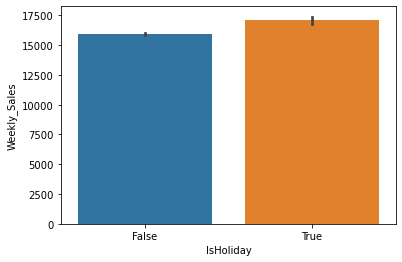

In [45]:
sns.barplot(x="IsHoliday", y="Weekly_Sales", data=data)

Sales increase when it is holiday time. So, let's examine in which holidays sales increase most.

In [46]:
data.index[data['IsHoliday']==True].unique()    # Holiday dates

DatetimeIndex(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
               '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
               '2012-02-10', '2012-09-07'],
              dtype='datetime64[ns]', name='Date', freq=None)

### Creating Features for each Holiday

In [47]:
data.loc[(data.index == '2010-02-12') | (data.index == '2011-02-11') | (data.index == '2012-02-10'), 'SuperBowl'] = 1
data.loc[(data.index != '2010-02-12') & (data.index != '2011-02-11') & (data.index != '2012-02-10'), 'SuperBowl'] = 0

data.loc[(data.index == '2010-09-10') | (data.index == '2011-09-11') | (data.index == '2012-09-07'), 'LaborDay'] = 1
data.loc[(data.index != '2010-09-10') & (data.index != '2011-09-11') & (data.index != '2012-09-07'), 'LaborDay'] = 0

data.loc[(data.index == '2010-11-26') | (data.index == '2011-11-25'), 'ThanksGiving'] = 1
data.loc[(data.index != '2010-11-26') & (data.index != '2011-11-25'), 'ThanksGiving'] = 0

data.loc[(data.index == '2010-12-31') | (data.index == '2011-12-30'), 'Christmas'] = 1
data.loc[(data.index != '2010-12-31') & (data.index != '2011-12-30'), 'Christmas'] = 0

In [48]:
data.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,Unemployment,Markdown_total,Markdown_cond,Week,Month,Year,SuperBowl,LaborDay,ThanksGiving,Christmas
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,False,A,151315,42.31,2.572,0.0,0.0,...,8.106,0.0,0,5,2,2010,0.0,0.0,0.0,0.0
2010-02-05,35,3,14612.19,False,B,103681,27.19,2.784,0.0,0.0,...,9.262,0.0,0,5,2,2010,0.0,0.0,0.0,0.0
2010-02-05,35,4,26323.15,False,B,103681,27.19,2.784,0.0,0.0,...,9.262,0.0,0,5,2,2010,0.0,0.0,0.0,0.0
2010-02-05,35,5,36414.63,False,B,103681,27.19,2.784,0.0,0.0,...,9.262,0.0,0,5,2,2010,0.0,0.0,0.0,0.0
2010-02-05,35,6,11437.81,False,B,103681,27.19,2.784,0.0,0.0,...,9.262,0.0,0,5,2,2010,0.0,0.0,0.0,0.0


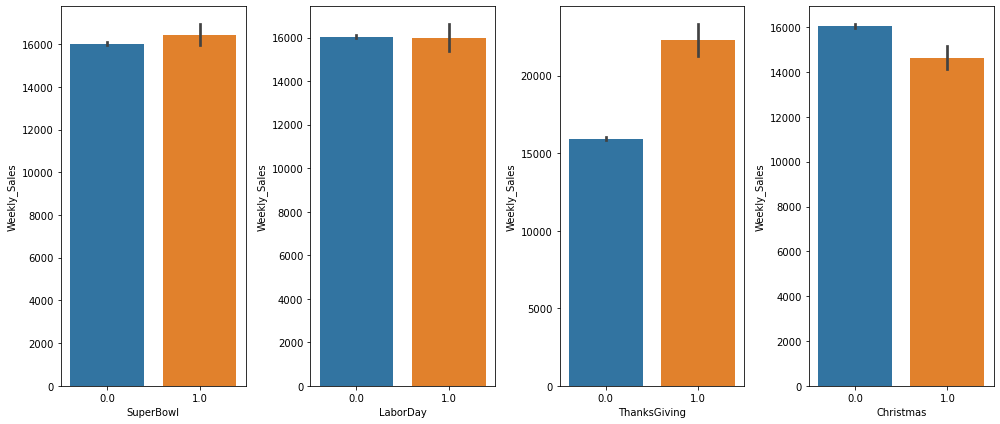

In [49]:
holidays= ['SuperBowl', 'LaborDay', 'ThanksGiving', 'Christmas']


fig, axes = plt.subplots(1, 4, figsize = (14, 6))
for i in list(range(4)):  
    sns.barplot(x=holidays[i], y='Weekly_Sales', data=data, ax=axes[i])
    plt.tight_layout()

Thanksgiving and Super Bowl positively affected sales. One should note that Black Friday (boosts sales) is in Thanksgiving week and Valentines Day is in Super Bowl week.
On the other hand, Labor Day and Christmas did not increase the sales. In general, it is known that people buy Christmas gift 1-2 weeks beforehand.

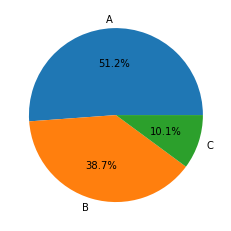

In [50]:
store_type = data.groupby(['Type'])['Store'].count()/len(data)*100
store_type

plt.pie(store_type.values, labels=store_type.index, autopct='%1.1f%%')
plt.show()

Let's see if store type is correlated to another feature. At the same time, other feature correlations can be inspected.

In [51]:
data['Type'] = [ord(x)-64 for x in data['Type']]

data.corr()['Type'].sort_values()[:3]

Size             -0.811541
Weekly_Sales     -0.182229
Markdown_total   -0.140767
Name: Type, dtype: float64

Store type is related to size of the store. Big, medium, small stores represented by type A,B,C.

# Correlation between features

<AxesSubplot:>

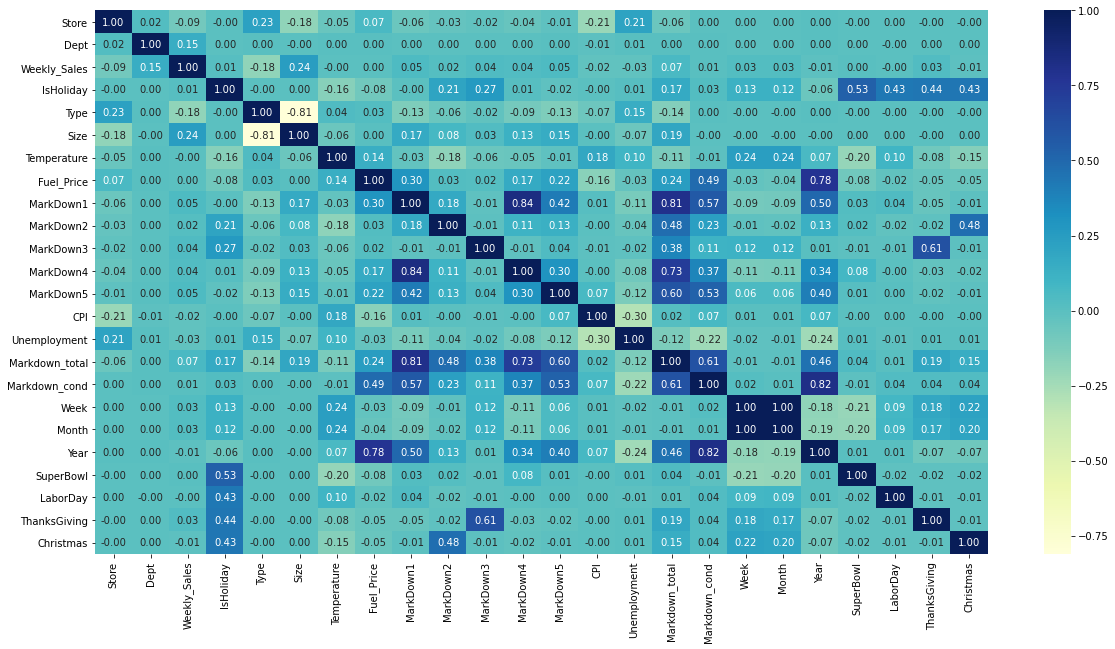

In [52]:
corr_data = data
plt.figure(figsize = (20,10))
sns.heatmap(corr_data.corr(), annot=True, cmap="YlGnBu", fmt='.2f')

In [53]:
data.sort_values('Weekly_Sales', ascending=False).head(10)

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,Unemployment,Markdown_total,Markdown_cond,Week,Month,Year,SuperBowl,LaborDay,ThanksGiving,Christmas
Date,,,,,,,,,,,,,,,,,,,,,
2010-11-26,10,72,693099.36,True,2,126512,55.33,3.162,0.00,0.0,...,9.003,0.00,0,47,11,2010,0.0,0.0,1.0,0.0
2011-11-25,35,72,649770.18,True,2,103681,47.88,3.492,1333.24,0.0,...,8.745,66304.31,1,47,11,2011,0.0,0.0,1.0,0.0
2011-11-25,10,72,630999.19,True,2,126512,60.68,3.760,174.72,329.0,...,7.874,143223.31,1,47,11,2011,0.0,0.0,1.0,0.0
2010-11-26,35,72,627962.93,True,2,103681,46.67,3.039,0.00,0.0,...,8.763,0.00,0,47,11,2010,0.0,0.0,1.0,0.0
2010-11-26,14,72,474330.10,True,1,200898,46.15,3.039,0.00,0.0,...,8.724,0.00,0,47,11,2010,0.0,0.0,1.0,0.0
2010-11-26,20,72,422306.25,True,1,203742,46.66,3.039,0.00,0.0,...,7.484,0.00,0,47,11,2010,0.0,0.0,1.0,0.0
2010-11-26,27,72,420586.57,True,1,204184,46.67,3.186,0.00,0.0,...,8.021,0.00,0,47,11,2010,0.0,0.0,1.0,0.0
2010-12-24,10,7,406988.63,False,2,126512,57.06,3.236,0.00,0.0,...,9.003,0.00,0,51,12,2010,0.0,0.0,0.0,0.0
2010-12-24,10,72,404245.03,False,2,126512,57.06,3.236,0.00,0.0,...,9.003,0.00,0,51,12,2010,0.0,0.0,0.0,0.0


## Exploration findings
- Sales, Stores and Features datasets are merged into one. Weekly sales below 0 are dropped and NaN values in Markdown columns are changed into 0. Holidays, week, month and year features are added as feature.
- There are 45 stores and 81 departments in the dataset.
- Sales increase significantly in Thanksgiving week.
- Most sales are in Thanksgiving week which includes Black Friday sales too.
- Some features are correlated with each other such as fuel price and year could cause multicollinearity. Also, some features has not strong relationship with target feature 'Weekly_sales' can be dropped.

## Train-test data

In [54]:
train_data, test_data = train_test(data, 0.90)

In [55]:
target = ['Weekly_Sales']
X_cols = [x for x in data.columns if x not in target]

In [56]:
X_train, y_train = train_data[X_cols], train_data['Weekly_Sales']    #dataframe and series
X_test, y_test = test_data[X_cols], test_data['Weekly_Sales']

## Models to fit and predict

In [57]:
model_rfr = RandomForestRegressor(n_estimators=50, random_state=1, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

# Making pipeline for scaler and regressor
scaler = RobustScaler()
rfr_pipe = make_pipeline(scaler, model_rfr)
rfr_pipe.fit(X_train, y_train)

# Predictions on test set
ypred_rfr = rfr_pipe.predict(X_test)

# Score on test set
rfr_all_res = mae(y_test, ypred_rfr)
rfr_all_res

6909.118851293785

Model with all features included gives quite high MAE score and therefore dropping some features can be helpful to decrease error terms because they are correlated with each other or no effect on target feature (weekly sales).

## Feature Engineering

In [58]:
X = data[X_cols] # All X values

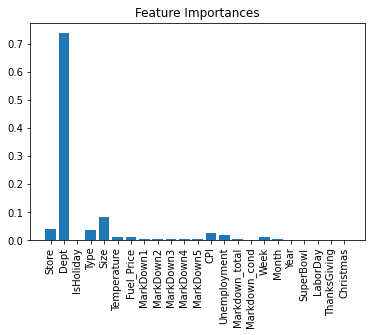

In [59]:
plt.bar(X.columns, model_rfr.feature_importances_)
plt.rcParams["figure.figsize"] = (10, 5)
plt.title('Feature Importances')
plt.xticks(rotation=90)
plt.show()

# https://mljar.com/blog/feature-importance-in-random-forest/

**Features sorted by their importance to model**

In [60]:
feature_importance = pd.DataFrame(list(zip(X.columns,model_rfr.feature_importances_)), columns=['Feature', 'Importance'])
top15_features = feature_importance.sort_values(by='Importance', ascending=False, ignore_index=True)[:15]
top15_features

,Feature,Importance
0,Dept,0.737597
1,Size,0.083423
2,Store,0.037824
3,Type,0.034104
4,CPI,0.023885
5,Unemployment,0.017554
6,Week,0.012092
7,Temperature,0.011719
8,Fuel_Price,0.010381
9,Month,0.005346


## Model rankings with most important n number of features included

In [61]:
X_cols= []
Scores = []
for i in range(len(top15_features)):
    X_cols.append(top15_features.iloc[i,0])
    data = data.copy()
    train_data, test_data = train_test(data)
    X_train, y_train = train_data[X_cols], train_data['Weekly_Sales']    #dataframe and series
    X_test, y_test = test_data[X_cols], test_data['Weekly_Sales']

    model_rfr = RandomForestRegressor(n_estimators=50, random_state=1, n_jobs=-1, max_depth=35,
                               max_features = 'sqrt',min_samples_split = 10)

    scaler = RobustScaler()
    #making pipe tp use scaler and regressor together
    rfr_pipe = make_pipeline(scaler,model_rfr)
    rfr_pipe.fit(X_train, y_train)

    # predictions on test set
    ypred_fea = rfr_pipe.predict(X_test)
    print('For top {} number of feature Mean Absolute Error is={}'.format(i+1, mae(y_test, ypred_fea)))
    Scores.append({'Feature_no':i+1, 'Score': mae(y_test, ypred_fea)})
scores_df = pd.DataFrame(Scores)
scores_df

For top 1 number of feature Mean Absolute Error is=8231.207690961173
For top 2 number of feature Mean Absolute Error is=2601.224908910613
For top 3 number of feature Mean Absolute Error is=2455.374599334716
For top 4 number of feature Mean Absolute Error is=2455.4336931541084
For top 5 number of feature Mean Absolute Error is=2797.703607990511
For top 6 number of feature Mean Absolute Error is=4141.026309752021
For top 7 number of feature Mean Absolute Error is=4625.801628934112
For top 8 number of feature Mean Absolute Error is=4953.720361046247
For top 9 number of feature Mean Absolute Error is=3822.229110253128
For top 10 number of feature Mean Absolute Error is=4147.632688494587
For top 11 number of feature Mean Absolute Error is=4709.032329586633
For top 12 number of feature Mean Absolute Error is=5285.42031161356
For top 13 number of feature Mean Absolute Error is=5593.937885655234
For top 14 number of feature Mean Absolute Error is=6165.054479969837
For top 15 number of feature 

,Feature_no,Score
0,1,8231.207691
1,2,2601.224909
2,3,2455.374599
3,4,2455.433693
4,5,2797.703608
5,6,4141.026310
6,7,4625.801629
7,8,4953.720361
8,9,3822.229110
9,10,4147.632688


**Features with Best Model**

In [62]:
scores_df[scores_df['Score']==scores_df['Score'].min()].style.hide_index()

Feature_no,Score
3,2455.374599


In [63]:
top15_features.loc[:2, 'Feature']

0     Dept
1     Size
2    Store
Name: Feature, dtype: object

So best model is with top 3 features: departmend id, size, store and type results in 2455.37 mean absolute error in test set.

I want to see if taking most important features (Dept, Size, Store) along with ones have significant effect on Weekly sales which are not correlated with other features improve the performance. Splitting dataset again into train-test sets according to this new set of features.

**Additional features experiment**

In [64]:
features_plus = ['Dept', 'Size', 'Store', 'ThanksGiving', 'Week']

X_train, y_train = train_data[features_plus], train_data['Weekly_Sales']    # Dataframe and series
X_test, y_test = test_data[features_plus], test_data['Weekly_Sales']

In [65]:
model_rfr = RandomForestRegressor(n_estimators=100, random_state=1, n_jobs=-1, max_depth=30,
                           max_features = 'log2', min_samples_split = 10)

model_rfr.fit(X_train, y_train)

# Predictions on test set
ypred_features_plus = model_rfr.predict(X_test)

# Score on test set
rfr_fplus_res = mae(y_test, ypred_features_plus)
rfr_fplus_res

1929.7311308058397

Yes, performance improved this way (error is decreased to 1929.73 from 2455.37). Therefore, this set of features will be evaluated in hyperparameter tuning. After that, predicted weekly sales will be plotted along with the test set and classical time-series model results for model evaluation. 

# Hyperparameter Tuning with Grid Search

In [66]:
param_grid = {'n_estimators': [50, 100], 
              'max_depth': [15, 30, 45],
              'max_features': ['log2', 'sqrt'],
              'min_samples_split': [10, 15],
              'random_state': [1],
              'n_jobs': [-1]}

In [67]:
grid_rfr = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv= 5)    #Grid Search function
grid_rfr.fit(X_train, y_train)

print("best score: ", grid_rfr.best_score_)
print("best param: ", grid_rfr.best_params_)

best score:  0.9488083795591085
best param:  {'max_depth': 45, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 1}


In [68]:
ypred_grid_rfr = grid_rfr.predict(X_test)
rfr_best_res = mae(y_test, ypred_grid_rfr)
rfr_best_res

1975.3518849374411

Hyperparameter tuning improved the performance of the most recent model.

# Prediction Graph

In [69]:
ypred_grid_rfr = list(zip(y_test.index.date, ypred_grid_rfr))

df_ypred = pd.DataFrame(ypred_grid_rfr, columns=['Date', 'ypred_grid_rfr'])
df_ypred['Date'] = pd.to_datetime(df_ypred['Date'])
df_ypred.set_index('Date', inplace=True)
df_ypred.head()

,ypred_grid_rfr
Date,
2012-07-20,18.081117
2012-07-20,402.612558
2012-07-20,36489.059055
2012-07-20,25306.171603
2012-07-20,21560.494210


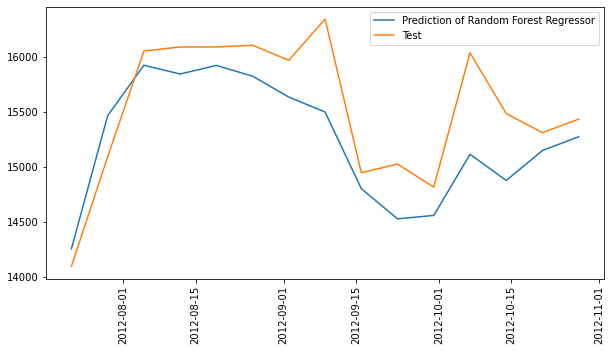

In [70]:
plt.plot(df_ypred.resample('W').mean(), label="Prediction of Random Forest Regressor")
plt.plot(y_test.resample('W').mean(), label="Test")
plt.xticks(rotation=90)
plt.legend(loc='best')

Pattern is predicted very well even though error is not small as much as classical time-series models.

## Model Comparison vs Classical Models on Test Data

In [71]:
new_results = pd.DataFrame({'Model Name': ['rfr_all_res', 'rfr_best_res'], 'MAE':[rfr_all_res, rfr_best_res]})
model_results = model_results.append(new_results, ignore_index=True).sort_values('MAE')
model_results

,Model Name,MAE
0,arima_res,447.715687
1,autoarima_res,514.553990
2,expsmoothing_res,837.756116
4,rfr_best_res,1975.351885
3,rfr_all_res,6909.118851


Text(0, 0.5, 'Weekly Sales')

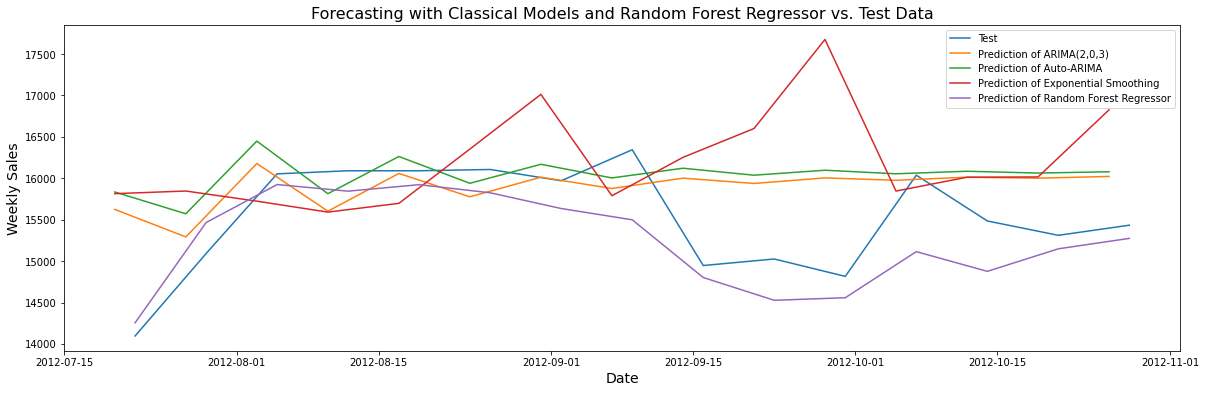

In [72]:
plt.figure(figsize=(20,6))
plt.plot(y_test.resample('W').mean(), label='Test')
plt.plot(ypred_arima, label='Prediction of ARIMA(2,0,3)')
plt.plot(ypred_autoarima, label='Prediction of Auto-ARIMA')
plt.plot(ypred_hw, label='Prediction of Exponential Smoothing')
plt.plot(df_ypred.resample('W').mean(), label="Prediction of Random Forest Regressor")

plt.title('Forecasting with Classical Models and Random Forest Regressor vs. Test Data', fontsize=16)
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)

Random forest regressor with the help of feature engineering has better performance than one with the all features included. Although, classical time-series models outperform random forest regressor even with best features selected. One can see that available features are not good enough to find patterns to predict target feature (weekly sales) in this dataset. In conclusion, ARIMA(2,0,3) model has the best performance and is most appropriate for forecasting.